# 4.Custom DataLoader

*Made by David Serrano for his Final Bachelor Thesis*

This file implements the **Dataset** and **Dataloaders** classes, as well as diving the dataset into training and test and balancing the training dataset.

**Dataset** stores the samples and their corresponding labels, and **DataLoader** wraps an iterable around the Dataset to enable easy access to the samples.

## 4.1. Environment Preparation


In [1]:
# Useful general imports
from google.colab import drive 

In [2]:
# mount the google drive folder to access to all the files in there
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Add the folder called utils that has all the custom modules in .py files
import sys
sys.path.append('/content/drive/MyDrive/TFG/utils')

In [4]:
from paths import PROJECT_ROOT, HDF5_FOLDER, JSON_FOLDER, USABLE_SEQUENCES, MAX_SQUARE_LEN

## 4.2. Dataset

We will use a map-style dataset, which is the one that implements *getitem()* and *len()* protocols, and represents a map from indices/keys to data samples.

* To initialize the **Dataset** object we need a list of all the hdf5Loaders (using *hdf5Initializer()*) , a list with the detections and a list of the labels in the same order of the detection list (using *detectionLoader()*) and the number of frames we want to take for each track.

* The length of the **Dataset** object is the number of tracks in the detection list. The length of the list trackIDs (using *trackLoader()*)

* To get one item the function *getitem()* needs an index as a parameter and follows the following steps: 

    1.   The previous mentioned function searches which track is in the position *index* and from which sequence is.  
    2.   Obtain all the detections from the track.
    3.   Obtain *n* equiespaced detections from all the detections of the track (using *sampleTrackDetections()*).
    4.   Obtain the images corresponding to the *n* detectioins.
    5.   Obtain the squared **MAX_SQUARE_LEN** x **MAX_SQUARE_LEN** images from the Bounding Boxes and the frames (using *crop_detection()*).
    6.   Triple the images to have 3 channels since the pretrained Neural Networks were trained with 3-channeled images.
    7.   Normalize the images in the range 0-1.
    8.   Transform the images to tensors.
    9.   Append the *n* images in the same tensor.
    10.  The output of the function is a tensor with the *n* images with the following shape:

        *torch.Size( [*n*, 3 MAX_LEN_SQUARE, MAX_LEN_SQUARE] )*

        and a tensor containing the label of the track.


In [5]:
import torch
from torch.utils.data import Dataset
import numpy as np
import random
import cv2

# Custom imports
from dataPrep import sampleTrackDetections, crop_detection, trackLoader

class Dataset(Dataset):
    def __init__(self, loaders, labels, detections, n=5,
                 dataAug='N', pixRange=5, degRange=5):
        'Initialization'
        self.loaders = loaders                  # List of hdf5Loaders
        self.trackIDs = trackLoader(detections) # List of all the trackIDs [seqNum, trackID, repNum]
        self.labels = labels                    # List of labels
        self.detections = detections            # List of detections
        self.n = n                              # Number of frames per track
        self.dataAug = dataAug                  # Data Augmentation option
                                                # 'N': no, 'Y': yes, 'P' percentage
        self.pixRange = pixRange                # Pixels change for Data Aug
        self.degRange = degRange                # Degree change for Data Aug
    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.trackIDs)

    def __getitem__(self, index):
        """
        Having all the hdf5Loaders, all the detections and all the labels,
        this function returns a tensor of size torch.Size([n, 3, 224, 224]) from
        the index passed as parameter. The function:
        1. searches for the track in position index
        2. obtains n equispaced frames f the track
        3, crops the detection in each frame
        4. resizes the image into a square of 224
        5. triples the image to have three channels
        6. normalize the images into the range 0-1
        7. transforms the images to tensors

        :return: tensor with torch.Size([n, 3, 224, 224])
        """
        # With the selected index obtain the sequence and trackID of the sample
        seqNum = self.trackIDs[index][0]
        trackID = self.trackIDs[index][1]
        repNum = self.trackIDs[index][2]

        # Get the frame samples of the whole track
            # First, obtain all the detections of the the track in question
            # and the label of the track
        track_detections = []
        for d, l in zip(self.detections, self.labels):
            if d[0] == seqNum and d[2] == trackID and d[7] == repNum:
                track_detections.append(d)
                y = l

            # Then obtain the equispaced samples of the track
        sample_detections = sampleTrackDetections(track_detections, self.n)

        # Load the images for all the sample detections
        # Get the BBoxes for all the sample detections
        # Crop and resize the detection from the image
        # Triple the image to have 3 channels
        # Normalize the image between 0 and 1
        # Transform the image to Tensor
        # Transform the list of images to Tensor

        first_d = True

        if self.dataAug == 'Y':
            rotation = random.uniform(-self.degRange, self.degRange)

            xDisp = random.uniform(-self.pixRange, self.pixRange)
            yDisp = random.uniform(-self.pixRange, self.pixRange)

            xSign = 1
            ySign = 1

        elif self.dataAug == 'P':
            rotation = random.uniform(-self.degRange, self.degRange)

            detMean = np.mean(np.array(sample_detections), axis=0)

            xDisp = int((detMean[5] - detMean[3]) * 0.1)
            yDisp = int((detMean[6] - detMean[4]) * 0.1)
            xSign = 1 if random.random() < 0.5 else -1
            ySign = 1 if random.random() < 0.5 else -1
        
        for d in sample_detections:

            image = self.loaders[(seqNum-1)].loadImage(d[1])

            if self.dataAug == 'Y' or self.dataAug == 'P':
                deltaX, deltaY = d[5] - d[3], d[6] - d[4]
                (cX, cY) = (d[3] + deltaX // 2, d[4] + deltaY // 2)
                M = cv2.getRotationMatrix2D((cX, cY), rotation, 1.0) 
                image = cv2.warpAffine(image, M,(image.shape[1], image.shape[0]))
                BBox = [d[3] + (xSign * xDisp), d[4] + (ySign * yDisp),
                        d[5] + (xSign * xDisp), d[6] + (ySign * yDisp)]
                # print('Pre-BBox',BBox)

                if BBox[0] < 0: BBox[0] = 0
                if BBox[1] < 0: BBox[0] = 0
                if BBox[2] > image.shape[1]: BBox[2] = image.shape[1] -1
                if BBox[3] > image.shape[0]: BBox[3] = image.shape[0] -1
                # print('Post-BBox',BBox)
            else:
                BBox = [d[3], d[4], d[5], d[6]]
            
            resized_img = crop_detection(image, BBox)
            resized_img = np.stack((resized_img,)*3, axis=-1)
            resized_img = np.moveaxis(resized_img, -1, 0)
            resized_img = ((1/4095) * resized_img).astype(np.float16)
            resized_img = torch.Tensor(resized_img)
            resized_img = torch.unsqueeze(resized_img, 0)
            if first_d==True:
                resized_images = resized_img
                first_d = False
            else:
                resized_images = torch.cat((resized_images, resized_img), 0)

        return resized_images, y

## 4.3. Splitting the Dataset

Now, with the **Dataset** funciton created, we can have a dataset that contains both the training and validation set. We could use the *SubsetRandomSampler* from torch.utils.data.sampler to split the dataset and the *WeightedRandomSampler* to balance it. However, it is not possible to use both of the samplers at the same time due to there only exists one sampler as a parameter in the DataLoader function. Moreover, the *WeightedRandomSampler* has been tested anyway, and its performance has been quite poor because of the extreme imbalancing of the classes.

So, a custom SubsetRandomSampler funtion is created to divide the dataset into two sets of 80% (train) and 20% (validation).

The following block randomly selects the 80% and 20% of all the detections classified by labels to obtain two diffent dataset with:

*   The 80% of the NHS, the 80% of the HS and the 80% of the AN.
*   THe 20% of the NHS, the 20% of the HS and the 20% of the AN.

In [6]:
import numpy as np
import random
import math

# Custom imports
from dataPrep import detectionLoader

def splitDataset(seqs, trainPercentage=0.8):
    """
    Function to split the dataset in training and validation with the percentage
    passed as a parameter. This function maintains the proportion of the labels
    in both of the new datasets.
    :param seqs: list of sequences names to load them
    :param trainPercentage: float with the percentage of the dataset which will
    go to training
    :return train_detections: detections of the training datasetç
    :return train_labels: labels of the training dataset
    :return validation_detections: detections of the validation dataset
    :return validation_labels: labels of the validation dataset
    """

    print("Splitting the dataset into 2 sets of {:.1f}/{:.1f}".format(trainPercentage,
                                                              1-trainPercentage))

    # Load 1 detection and 1 label per track
    detections, labels = detectionLoader(seqs, tracks=True)

    # List of the detections of each label
    d_NHS = []
    d_HS = []
    d_AN = []

    # Classify the detections by labels
    for detection, label in zip(detections, labels):
        if label == 0:
            d_NHS.append(detection)
        elif label == 1:
            d_HS.append(detection)
        elif label == 2:
            d_AN.append(detection)

    # The 80% of each class has to go to the train_dataset
    # The other 20% to the validation_dataset
    num_train_NHS = math.floor(trainPercentage * len(d_NHS))
    num_train_HS = math.floor(trainPercentage * len(d_HS))
    num_train_AN = math.floor(trainPercentage * len(d_AN))

    # Shuffle the list and take the first 80% of the detecions and the last 20%
    random.seed(42)
    random.shuffle(d_NHS)
    random.shuffle(d_HS)
    random.shuffle(d_AN)

    # Training dataset and labels
    train_detections = []
    train_labels = []

    train_detections = d_NHS[:num_train_NHS] + d_HS[:num_train_HS] + d_AN[:num_train_AN]
    train_labels = np.concatenate((np.zeros(num_train_NHS, dtype=int),
                                np.ones(num_train_HS, dtype=int),
                                2 * np.ones(num_train_AN, dtype=int)))
    train_labels = train_labels.tolist()

    # Validation dataset and labels
    validation_detections = []
    validation_labels = []

    validation_detections = d_NHS[num_train_NHS:] + d_HS[num_train_HS:] + d_AN[num_train_AN:]
    validation_labels = np.concatenate((np.zeros(len(d_NHS) - num_train_NHS, dtype=int),
                                np.ones(len(d_HS) - num_train_HS, dtype=int),
                                2 * np.ones(len(d_AN) - num_train_AN, dtype=int)))
    validation_labels = validation_labels.tolist()

    # Shuffle both datasets
    z = list(zip(train_detections, train_labels))
    random.shuffle(z)
    train_detections, train_labels = zip(*z)

    z = list(zip(validation_detections, validation_labels))
    random.shuffle(z)
    validation_detections, validation_labels = zip(*z)

    return train_detections, train_labels, validation_detections, validation_labels

Now, to demonstrate how the previous function works, a bar plot, as well as the label count, is shown to allow the user have a general conception of how the dataset is split.

Splitting the dataset into 2 sets of 0.8/0.2


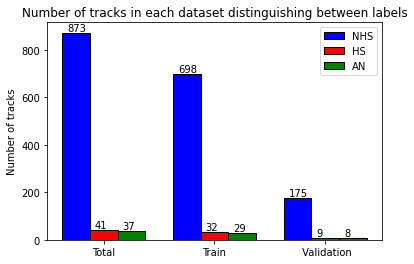


######### OUTPUT #########

Initial dataset:
NHS: 873
HS: 41
AN: 37
TOTAL: 951

Train Dataset:
NHS: 698
HS: 32
AN: 29
TOTAL: 759

Train Dataset:
NHS: 175
HS: 9
AN: 8
TOTAL: 192


In [7]:
import matplotlib.pyplot as plt

# Custom imports
from dataPrep import detectionLoader, labelCounter

# Obtain the split datasets
train_detections, train_labels, validation_detections, validation_labels = splitDataset(USABLE_SEQUENCES,
                                                                          trainPercentage=0.8)

# Obtain the total dataset
detections, labels = detectionLoader(USABLE_SEQUENCES, tracks=True)

# Plot
n_groups = 3

index = np.arange(n_groups)
bar_width = 0.25

rects1 = plt.bar(index, (labels.count(0),
                         train_labels.count(0),
                         validation_labels.count(0)),
                 bar_width, color='b', ec="black", label='NHS')

rects2 = plt.bar(index + bar_width, (labels.count(1),
                                     train_labels.count(1),
                                     validation_labels.count(1)),
                 bar_width, color='r', ec="black", label='HS')

rects3 = plt.bar(index + 2*bar_width, (labels.count(2),
                                         train_labels.count(2),
                                         validation_labels.count(2)),
                 bar_width, color='g', ec="black", label='AN')

plt.ylabel('Number of tracks')
plt.title('Number of tracks in each dataset distinguishing between labels')
plt.xticks(index + bar_width, ('Total', 'Train', ' Validation'))

# Print the number above the bars
xlocs = []
for i in index:
    xlocs.append(i)
    xlocs.append(i + bar_width)
    xlocs.append(i + 2*bar_width)

y = [labels.count(0), labels.count(1), labels.count(2),
     train_labels.count(0), train_labels.count(1), train_labels.count(2), 
     validation_labels.count(0), validation_labels.count(1),
     validation_labels.count(2)]

for idx, v in enumerate(y):
    plt.text(xlocs[idx] - 0.08, v + 8, v)

# plt.tight_layout()
plt.legend()
plt.show()

print('\n######### OUTPUT #########\n')
print('Initial dataset:')
labelCounter(labels)
print('\nTrain Dataset:')
labelCounter(train_labels)
print('\nTrain Dataset:')
labelCounter(validation_labels)

## 4.4. Balancing the Train Dataset

As it is said before, the following block creates a function which balance the dataset. This is done with any type of data augmentation by now, repeating the classes with least number of appearances to level them with the class which has the most.

In [8]:
import numpy as np
import math

def balanceDataset(detections, labels, shuffle=True):
    """
    Function to split the dataset without data augmentation. The function
    repeats the classes with the least number of appearances to level them with
    the class which has the most.
    :param detections: detections
    :param labels: labels
    :param shuffle: if true, shuffle the balanced dataset
    :return detections_balanced: balanced detections
    :returm labels_balanced: balanced detections
    """

    print('Balancing the dataset...')
    # List of the detections of each label
    d_NHS = []
    d_HS = []
    d_AN = []

    # Classify the detections by labels
    for detection, label in zip(detections, labels):
        if label == 0:
            d_NHS.append(detection)
        elif label == 1:
            d_HS.append(detection)
        elif label == 2:
            d_AN.append(detection)
    
    # Find the maximum number of detections of the same label
    # and from which label it is
    max_len = max(len(d_NHS), len(d_HS), len(d_AN))

    detections_balanced = []
    labels_balanced = []

    for i in range(math.floor(max_len/len(d_NHS))):
        for d in d_NHS:
            detections_balanced.append([d[0],d[1],d[2],d[3],d[4],d[5],d[6],i])
            labels_balanced.append(0)

    for i in range(math.floor(max_len/len(d_HS))):
        for d in d_HS:
            detections_balanced.append([d[0],d[1],d[2],d[3],d[4],d[5],d[6],i])
            labels_balanced.append(1)
    
    for i in range(math.floor(max_len/len(d_AN))):
        for d in d_AN:
            detections_balanced.append([d[0],d[1],d[2],d[3],d[4],d[5],d[6],i])
            labels_balanced.append(2)
  
    if shuffle:
        z = list(zip(detections_balanced, labels_balanced))
        random.shuffle(z)
        detections_balanced, labels_balanced = zip(*z)

    return detections_balanced, labels_balanced

As after invoking the previous function is the final step of creating the desirable datasets, the function will be shown with a few batches after the creation of the DataLoaders.

## 4.5. Creating the DataLoaders

In the following block, a function which is capable of creating the DataLoaders is created.

In [9]:
from torch.utils.data import DataLoader

def getDataLoaders(loaders,
                   train_detections, train_labels,
                   validation_detections, validation_labels,
                   train_bs, val_bs,
                   dataAug='N', pixRange=5, degRange=5):
    """
    Funciton to create the train and validation dataloaders
    :param loaders: list of the sequence hdf5Loaders
    :param train_detections: list of train detections
    :param train_labels: list of train labels
    :param validation_detections: list of validation detections
    :param validation_labels: list of validation labels
    :train_bs: batch size of the train DataLoader
    :val_bs: batch size of the validation DataLoader
    :return train_dataloader: train DataLoader
    :return validation_dataloader: validation DataLoader
    """
    print('Creating the DataLoaders...')

    train_dataset = Dataset(loaders, train_labels,
                            train_detections, n=5, dataAug=dataAug,
                            pixRange=pixRange, degRange=degRange)
    
    validation_dataset = Dataset(loaders, validation_labels,
                                validation_detections)
    
    # batch sizes are the number of tracks in one batch. This means that the
    # real number of images loaded at the same time is the batch size multiplied
    # by n, e.g. n=5, batch_size=7 -> images per batch = 7 * 5 = 35
    train_dataloader = DataLoader(dataset=train_dataset,
                                batch_size=train_bs,
                                num_workers=2)

    validation_dataloader = DataLoader(dataset=validation_dataset,
                                batch_size=val_bs,
                                num_workers=2)
    
    return train_dataloader, validation_dataloader

To show how the *balanceDataset()* and *getDataLoaders()* funcitons work, in the following blocks an example code is called.

A bar plot and a label count is done to allow the user realise how the dataset are.

The output shoud be:
* The training set completely balanced (more or less the same occurrence for the three labels)
* The validation set extremely imbalanced since that is how really the dataset is.

In [10]:
from dataPrep import hdf5Initializer

loaders = hdf5Initializer(USABLE_SEQUENCES)

train_detections, train_labels, validation_detections, validation_labels = splitDataset(USABLE_SEQUENCES,
                                                                                        trainPercentage=0.8)

train_detections, train_labels = balanceDataset(train_detections, train_labels, shuffle=True)

train_dataloader, validation_dataloader = getDataLoaders(loaders,
                                                         train_detections,
                                                         train_labels,
                                                         validation_detections,
                                                         validation_labels,
                                                         train_bs=7,
                                                         val_bs=12,
                                                         dataAug='P')

Splitting the dataset into 2 sets of 0.8/0.2
Balancing the dataset...
Creating the DataLoaders...


Total elapsed time reading all the batches: 9.53 min



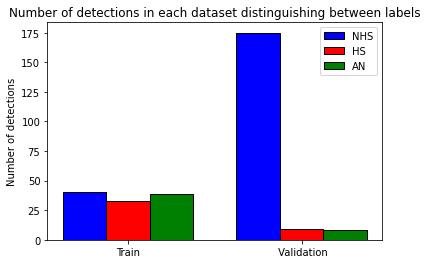


######### OUTPUT #########

Training dataset (balanced):
	NHS: 40
	HS: 33
	AN: 39

Validation dataset (imbalanced):
	NHS: 175
	HS: 9
	AN: 8


In [11]:
import time
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

tTotal = time.time()

train_counter_NHS = 0
train_counter_HS = 0
train_counter_AN = 0

validation_counter_NHS = 0
validation_counter_HS = 0
validation_counter_AN = 0

t = time.time()


loop = tqdm(train_dataloader, unit='batch', leave=False)
loop.set_description('Loading 16 batches of the training DataLoader')

count = 0
for data, labels in loop:
    train_counter_NHS = train_counter_NHS + (labels == 0).sum()
    train_counter_HS = train_counter_HS + (labels == 1).sum()
    train_counter_AN = train_counter_AN + (labels == 2).sum()
    count = count + 1
    if count == 16:
        break

elapsed = time.time() - t

t = time.time()

loop = tqdm(validation_dataloader, unit='batch', leave=False)
loop.set_description('Loading all the validation batches (16)')

for data, labels in loop:
    validation_counter_NHS = validation_counter_NHS + (labels == 0).sum()
    validation_counter_HS = validation_counter_HS + (labels == 1).sum()
    validation_counter_AN = validation_counter_AN + (labels == 2).sum()
elapsed = time.time() - t

eT = time.time() - tTotal
print('Total elapsed time reading all the batches: {:.2f} min\n'.format(eT/60))

# Plot
n_groups = 2

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25

rects1 = plt.bar(index, (train_counter_NHS, validation_counter_NHS),
                 bar_width, color='b', ec="black", label='NHS')

rects2 = plt.bar(index + bar_width, (train_counter_HS,
                                     validation_counter_HS),
                 bar_width, color='r', ec="black", label='HS') 

rects3 = plt.bar(index + 2*bar_width, (train_counter_AN,
                                     validation_counter_AN),
                 bar_width, color='g', ec="black", label='AN')      
        
plt.ylabel('Number of detections')
plt.title('Number of detections in each dataset distinguishing between labels')
plt.xticks(index + bar_width, ('Train', ' Validation'))

plt.legend()
plt.show()

print('\n######### OUTPUT #########\n')
print('Training dataset (balanced):')
print('\tNHS: {}'.format(train_counter_NHS))
print('\tHS: {}'.format(train_counter_HS))
print('\tAN: {}'.format(train_counter_AN))
print('\nValidation dataset (imbalanced):')
print('\tNHS: {}'.format(validation_counter_NHS))
print('\tHS: {}'.format(validation_counter_HS))
print('\tAN: {}'.format(validation_counter_AN))

In [12]:
det = [[200, 400, 300, 700],
       [400, 600, 500, 700],
       [0, 600, 1000, 700]]

detMean = np.mean(np.array(det), axis=0).astype(int)
print(detMean * 0.1)





[20.  53.3 60.  70. ]
